In [1]:
# Dependencies
import librosa
import librosa.display
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, Dropout
import numpy as np
import os
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, Activation, Input
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import IPython.display as ipd
from glob import glob
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
from IPython.display import Audio
from keras.models import load_model
import librosa
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, Input
import matplotlib.pyplot as plt
import music21
from pydub import AudioSegment
import json
from IPython.display import HTML, Javascript, display
import joblib

In [2]:
# Load audio file and extract chroma features
audio_files = glob(r'C:\Users\CJHx6\OneDrive\AI_Class\GIT\Group_3_Project\Resources\guitar-notes\Notes Datasets\*\*.wav')


In [3]:
# Load and preprocess the audio data
def add_white_noise(data, noise_level=0.005):
    max_amplitude = np.max(np.abs(data))
    noise_amp = noise_level * max_amplitude
    white_noise = noise_amp * np.random.normal(size=len(data))
    noisy_data = data + white_noise
    return noisy_data

def time_stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=rate)

def time_shift(data, max_shift_ms=50):
    shift_range = int(np.random.uniform(low=-max_shift_ms, high=max_shift_ms) * 1000)
    return np.roll(data, shift_range)

def random_pitch_shift(data, sr, pitch_range=(-2, 2)):
    pitch_shift_semitones = np.random.uniform(*pitch_range)
    pitch_factor = 2 ** (pitch_shift_semitones / 12.0)
    return librosa.effects.pitch_shift(data, sr=sr, n_steps=pitch_factor)

In [4]:
# Extract features from audio
def extract_features(file_path, num_mfcc=13, n_fft=2048, hop_length=512, mfcc_len=100):
    audio, sr = librosa.load(file_path, sr=None)    
    audio = add_white_noise(audio)
    audio = time_stretch(audio)
    audio = time_shift(audio)
    audio = random_pitch_shift(audio, sr)
    
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
    mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=n_fft, hop_length=hop_length)
    chroma = librosa.feature.chroma_stft(y=audio, sr=sr, n_fft=n_fft, hop_length=hop_length)
    contrast = librosa.feature.spectral_contrast(y=audio, sr=sr, n_fft=n_fft, hop_length=hop_length)
    
    if mfccs.shape[1] < mfcc_len:
        mfccs = np.pad(mfccs, ((0, 0), (0, mfcc_len - mfccs.shape[1])), mode='constant')
        mel_spectrogram = np.pad(mel_spectrogram, ((0, 0), (0, mfcc_len - mel_spectrogram.shape[1])), mode='constant')
        chroma = np.pad(chroma, ((0, 0), (0, mfcc_len - chroma.shape[1])), mode='constant')
        contrast = np.pad(contrast, ((0, 0), (0, mfcc_len - contrast.shape[1])), mode='constant')
    else:
        mfccs = mfccs[:, :mfcc_len]
        mel_spectrogram = mel_spectrogram[:, :mfcc_len]
        chroma = chroma[:, :mfcc_len]
        contrast = contrast[:, :mfcc_len]
    
    features = np.vstack((mfccs, mel_spectrogram, chroma, contrast))
    label = os.path.basename(os.path.dirname(file_path)).split('. ')[1]
    
    return features, label

In [5]:
# Function to process the entire dataset
def process_dataset(dataset_path, mfcc_len=100):
    data = []
    labels = []
    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            if file.endswith('.wav'):
                file_path = os.path.join(root, file)
                features, label = extract_features(file_path, mfcc_len=mfcc_len)
                data.append(features)
                labels.append(label)
    return data, labels

In [6]:
# Process the entire dataset
dataset_path = r'C:\Users\CJHx6\OneDrive\AI_Class\GIT\Group_3_Project\Resources\guitar-notes\Notes Datasets'
data, labels = process_dataset(dataset_path)

C:\Users\CJHx6\anaconda3\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


In [7]:
# Converting data to a DataFrame
data = np.array(data)
data_flat = np.array([d.flatten() for d in data])
df = pd.DataFrame(data_flat)
df['label'] = labels
df = df.sample(frac=1).reset_index(drop=True)

In [8]:
# Split the data into training, validation, and testing sets
X = df.iloc[: ,:-1].values
Y = df['label'].values
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42, shuffle=True)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.7, random_state=42, shuffle=True)

In [9]:
# Normalize the data
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_val = scaler.transform(x_val)
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)
x_val = np.expand_dims(x_val, axis=-1)

In [10]:
from keras.layers import Input

# Build and compile the CNN model
model = Sequential()
model.add(Input(shape=(x_train.shape[1], 1)))
model.add(Conv1D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(256, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(encoder.categories_[0]), activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
# Train the model
history = model.fit(x_train, y_train, epochs=45, batch_size=64, validation_data=(x_val, y_val), verbose=1)

Epoch 1/45
29/29 ━━━━━━━━━━━━━━━━━━━━ 30s 978ms/step - accuracy: 0.0341 - loss: 5.1434 - val_accuracy: 0.3529 - val_loss: 3.0516
Epoch 2/45
29/29 ━━━━━━━━━━━━━━━━━━━━ 28s 979ms/step - accuracy: 0.2252 - loss: 2.9982 - val_accuracy: 0.6103 - val_loss: 1.8303
Epoch 3/45
29/29 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.4102 - loss: 2.2137 - val_accuracy: 0.8824 - val_loss: 0.8695
Epoch 4/45
29/29 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.5947 - loss: 1.5387 - val_accuracy: 0.9265 - val_loss: 0.5062
Epoch 5/45
29/29 ━━━━━━━━━━━━━━━━━━━━ 29s 994ms/step - accuracy: 0.6857 - loss: 1.0942 - val_accuracy: 0.9632 - val_loss: 0.2625
Epoch 6/45
29/29 ━━━━━━━━━━━━━━━━━━━━ 29s 990ms/step - accuracy: 0.7726 - loss: 0.7889 - val_accuracy: 0.9779 - val_loss: 0.2339
Epoch 7/45
29/29 ━━━━━━━━━━━━━━━━━━━━ 29s 998ms/step - accuracy: 0.7932 - loss: 0.6986 - val_accuracy: 0.9632 - val_loss: 0.1568
Epoch 8/45
29/29 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.8262 - loss: 0.6043 - val_accuracy: 0.9

In [12]:
# Evaluate the model
loss, accuracy = model.evaluate(x_val, y_val)
print(f'Validation Loss: {loss:.3f}')
print(f'Validation Accuracy: {accuracy:.3f}')

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.9882 - loss: 0.0405  
Validation Loss: 0.050
Validation Accuracy: 0.985


In [13]:
# Save the trained model
model.save('guitar_chord_recognition_model.keras', include_optimizer=False)
print("Model saved successfully.")

joblib.dump(encoder, 'encoder.pkl') 
joblib.dump(scaler, 'scaler.pkl')

Model saved successfully.


['scaler.pkl']

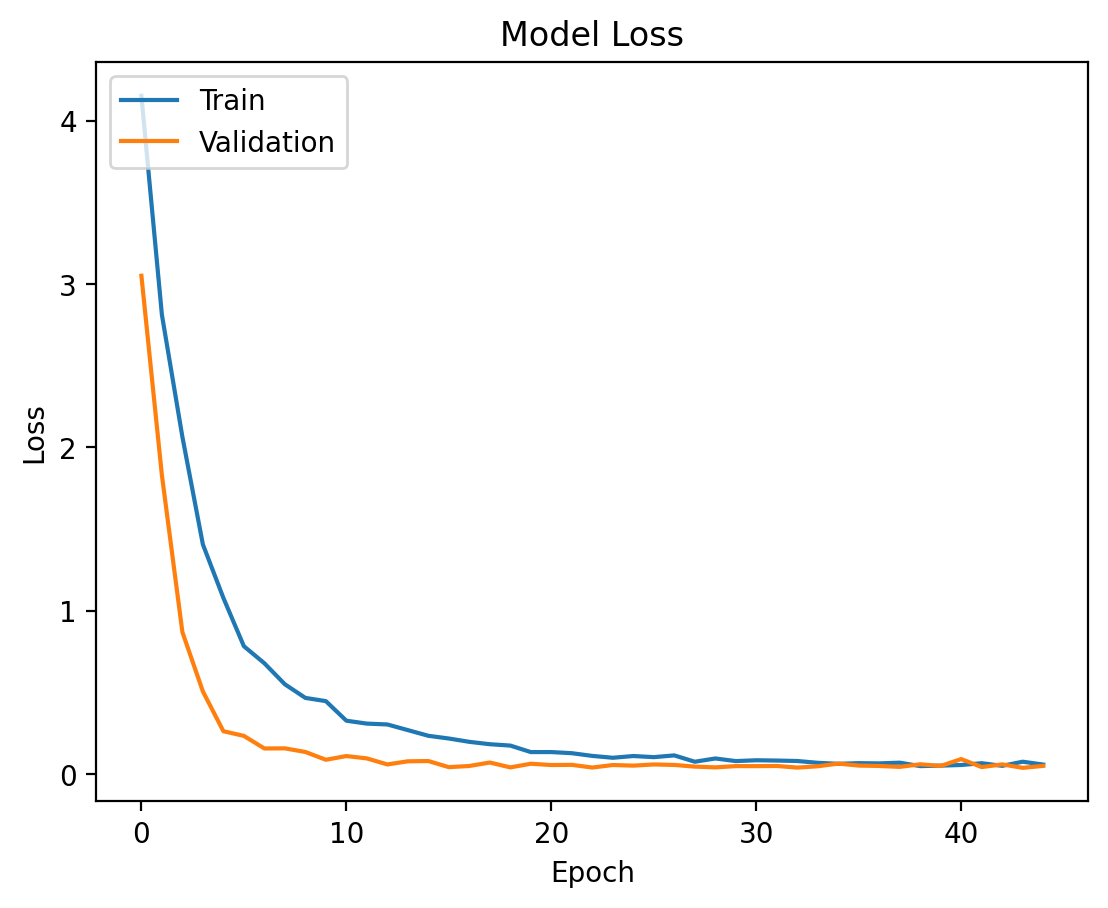

In [14]:
# Plot the training history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [15]:
# Load the trained model
model = load_model('guitar_chord_recognition_model.keras')
print("Model loaded successfully.")

# Recompile the model with the same optimizer and loss function
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print("Model recompiled successfully.")


Model loaded successfully.
Model recompiled successfully.


In [16]:
# Function to convert MP3 to WAV 
def convert_mp3_to_wav(mp3_file_path, wav_file_path='converted_audio_file.wav'): 
    audio = AudioSegment.from_mp3(mp3_file_path) 
    audio = audio.set_frame_rate(16000).set_channels(1) 
    audio.export(wav_file_path, format="wav") 
    return wav_file_path


In [17]:
# Function to split audio into chunks
def split_audio(file_path, chunk_duration=3): # 3 seconds per chunk 
    y, sr = librosa.load(file_path, sr=None) 
    total_duration = librosa.get_duration(y=y, sr=sr) 
    chunks = [] 
    for i in range(0, int(total_duration), chunk_duration): 
        start_sample = i * sr 
        end_sample = start_sample + chunk_duration * sr 
        chunks.append(y[start_sample:end_sample]) 
        return chunks, sr

In [18]:
# Function to extract features from chunk
def extract_features_from_chunk(chunk, sr, mfcc_len=100): 
    if np.mean(np.abs(chunk)) < 0.01: 
        return None # Skip silent chunks 
    mfccs = librosa.feature.mfcc(y=chunk, sr=sr, n_mfcc=13, n_fft=2048, hop_length=512) 
    mel_spectrogram = librosa.feature.melspectrogram(y=chunk, sr=sr, n_fft=2048, hop_length=512) 
    chroma = librosa.feature.chroma_stft(y=chunk, sr=sr, n_fft=2048, hop_length=512) 
    contrast = librosa.feature.spectral_contrast(y=chunk, sr=sr, n_fft=2048, hop_length=512) 
    if mfccs.shape[1] < mfcc_len: 
        mfccs = np.pad(mfccs, ((0, 0), (0, mfcc_len - mfccs.shape[1])), mode='constant') 
        mel_spectrogram = np.pad(mel_spectrogram, ((0, 0), (0, mfcc_len - mel_spectrogram.shape[1])), mode='constant') 
        chroma = np.pad(chroma, ((0, 0), (0, mfcc_len - chroma.shape[1])), mode='constant') 
        contrast = np.pad(contrast, ((0, 0), (0, mfcc_len - contrast.shape[1])), mode='constant') 
    else: 
        mfccs = mfccs[:, :mfcc_len] 
        mel_spectrogram = mel_spectrogram[:, :mfcc_len] 
        chroma = chroma[:, :mfcc_len] 
        contrast = contrast[:, :mfcc_len] 
    features = np.vstack((mfccs, mel_spectrogram, chroma, contrast)) 
    return features

In [19]:
# Function to predict chords for chunks
def predict_chords_for_chunks(chunks, sr, model, encoder, scaler, mfcc_len=100):
    predicted_chords = []
    for chunk in chunks:
        # Extract features
        features = extract_features_from_chunk(chunk, sr, mfcc_len)
        if features is None:
            continue
        features_flat = features.flatten().reshape(1, -1)
        features_scaled = scaler.transform(features_flat)
        features_scaled = np.expand_dims(features_scaled, axis=-1)
        prediction = model.predict(features_scaled)
        predicted_label_index = np.argmax(prediction)
        predicted_label = encoder.inverse_transform(np.array([np.eye(len(encoder.categories_[0]))[predicted_label_index]])).reshape(-1)
        predicted_chords.append(predicted_label[0])
    return predicted_chords

In [20]:
# Function to validate chord names
def is_valid_chord(chord_name):
    try:
        music21.chord.Chord(chord_name)
        return True
    except music21.pitch.AccidentalException:
        return False
    except music21.pitch.PitchException:
        return False

# Function to generate sheet music
def generate_sheet_music(predicted_chords):
    sc = music21.stream.Score()
    bpm = 120  # Example BPM
    a = music21.tempo.MetronomeMark(number=bpm)
    sc.insert(0, a)
    for chord in predicted_chords:
        d = 'half'  # Example duration
        if chord == 'Rest':
            sc.append(music21.note.Rest(type=d))
        else:
            if is_valid_chord(chord):
                sc.append(music21.chord.Chord(chord, type=d))
            else:
                print(f"Invalid chord detected: {chord}. Skipping or replacing with default.")
                # Replace invalid chords with a default valid chord (e.g., C major)
                sc.append(music21.chord.Chord('C', type=d))
    return sc

def show_score(score):
    xml = open(score.write('musicxml')).read()
    show_music_xml(xml)

def show_music_xml(xml):
    DIV_ID = "OSMD_div"
    display(HTML('<div id="'+DIV_ID+'">loading OpenSheetMusicDisplay</div>'))
    script = """
    var div_id = %%DIV_ID%%;
    function loadOSMD() { 
        return new Promise(function(resolve, reject){
            if (window.opensheetmusicdisplay) {
                return resolve(window.opensheetmusicdisplay)
            }
            // OSMD script has a 'define' call which conflicts with requirejs
            var _define = window.define // save the define object 
            window.define = undefined // now the loaded script will ignore requirejs
            var s = document.createElement( 'script' );
            s.setAttribute( 'src', "https://cdn.jsdelivr.net/npm/opensheetmusicdisplay@0.7.6/build/opensheetmusicdisplay.min.js" );
            s.onload=function(){
                window.define = _define
                resolve(opensheetmusicdisplay);
            };
            document.body.appendChild( s ); // browser will try to load the new script tag
        }) 
    }
    loadOSMD().then((OSMD)=>{
        window.openSheetMusicDisplay = new OSMD.OpenSheetMusicDisplay(div_id, {
          drawingParameters: "compacttight"
        });
        openSheetMusicDisplay
            .load(%%data%%)
            .then(
              function() {
                openSheetMusicDisplay.render();
              }
            );
    })
    """.replace('%%DIV_ID%%',DIV_ID).replace('%%data%%',json.dumps(xml))
    display(Javascript(script))
    return


In [21]:
# Example usage
mp3_file_path = r'C:\Users\CJHx6\OneDrive\AI_Class\GIT\Group_3_Project\notebooks\corey_exploration\Skillet - Hero.mp3'
wav_file_path = convert_mp3_to_wav(mp3_file_path)
chunks, sr = split_audio(wav_file_path)
predicted_chords = predict_chords_for_chunks(chunks, sr, model, encoder, scaler)
score = generate_sheet_music(predicted_chords)
show_score(score)

C:\Users\CJHx6\anaconda3\Lib\site-packages\pydub\utils.py:300: SyntaxWarning: invalid escape sequence '\('
  m = re.match('([su]([0-9]{1,2})p?) \(([0-9]{1,2}) bit\)$', token)
C:\Users\CJHx6\anaconda3\Lib\site-packages\pydub\utils.py:301: SyntaxWarning: invalid escape sequence '\('
  m2 = re.match('([su]([0-9]{1,2})p?)( \(default\))?$', token)
C:\Users\CJHx6\anaconda3\Lib\site-packages\pydub\utils.py:310: SyntaxWarning: invalid escape sequence '\('
  elif re.match('(flt)p?( \(default\))?$', token):
C:\Users\CJHx6\anaconda3\Lib\site-packages\pydub\utils.py:314: SyntaxWarning: invalid escape sequence '\('
  elif re.match('(dbl)p?( \(default\))?$', token):


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\CJHx6\\OneDrive\\AI_Class\\GIT\\Group_3_Project\\notebooks\\corey_exploration\\Skillet - Hero.mp3'

In [ ]:
# GENERATING SHEET MUSIC (USING music21)
from music21 import stream, note, chord, duration

def generate_sheet_music(chord_predictions, output_path="sheet_music.xml"):
    music_stream = stream.Stream()
    for chord_name, start_time, end_time in chord_predictions:
        n = note.TextChordSymbol()
        n.addChordStep(chord_name)
        n.quarterLength = (end_time - start_time) * 4  # Adjust based on your tempo
        music_stream.append(n)
    music_stream.write('musicxml', fp=output_path)

In [ ]:
# Example Usage
# Assuming predict_chords returns a list of chords, one for each segment
example_chords = ["C", "G", "Am", "F"]
generate_sheet_music(example_chords)

In [ ]:
# FUNCTION FOR LOADING SAVED MODEL
def load_model():
    return tf.keras.models.load_model("guitar_chord_recognition_model.keras")

In [ ]:
# FUNCTION TO PROCESS NEW SONG
def process_new_song(audio_path):
    y, sr = librosa.load(audio_path)
    # Extracting features (e.g., MFCCs, chroma)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    mfccs_mean = np.mean(mfccs.T, axis=0)
    return mfccs_mean.reshape(1, -1)  # Reshape for prediction

In [ ]:
# FUNCTION TO PREDICT CHORDS
def predict_chords(audio_path):
    model = load_model()
    features = process_new_song(audio_path)
    prediction = model.predict(features)
    predicted_label = encoder.inverse_transform([np.argmax(prediction)])
    return predicted_label

In [ ]:
# TESTING THE NEW SONG FUNCTION
new_audio_path = r'C:\Users\CJHx6\OneDrive\AI_Class\GIT\Group_3_Project\notebooks\corey_exploration\converted_audio_file.wav'
print("Predicted chord for the new song:", predict_chords(new_audio_path))
